In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from paraspec import ParapatricSpeciationModel

%matplotlib inline

# Run the model in a static landscape

In [2]:
length = (25, 25)
spacing = (1, 1)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

elevation = Y * 100 + np.random.random(X.shape) 

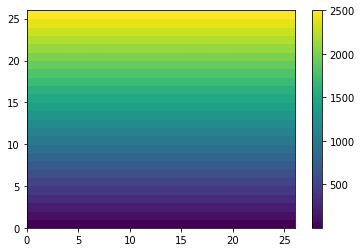

In [3]:
plt.pcolormesh(elevation)
plt.colorbar();

In [4]:
pop_size = 100

model = ParapatricSpeciationModel(X, Y, pop_size,
                                  nb_radius=5, capacity=28,
                                  sigma_w=50, sigma_d=0.5, sigma_mut=50,
                                  lifespan=1, m_freq=0.05)

model.initialize_population([elevation.min(), elevation.max()])

dfs = []

for step in range(50):
    if step % 5 == 0:
        dfs.append(model.to_dataframe())
    
    model.update_population(elevation, 5)
    
population = pd.concat(dfs)

In [5]:
population.head()

,generation,x,y,trait
0,0,9.420663,13.377342,2215.867275
1,0,13.268268,20.153083,1789.605242
2,0,4.724257,22.840476,1333.026346
3,0,0.510088,12.072500,1096.553871
4,0,15.536736,8.560329,584.183823


In [6]:
population.groupby('generation').count()

,x,y,trait
generation,,,
0,100,100,100
5,171,171,171
10,182,182,182
15,167,167,167
20,164,164,164
25,175,175,175
30,177,177,177
35,203,203,203
40,181,181,181


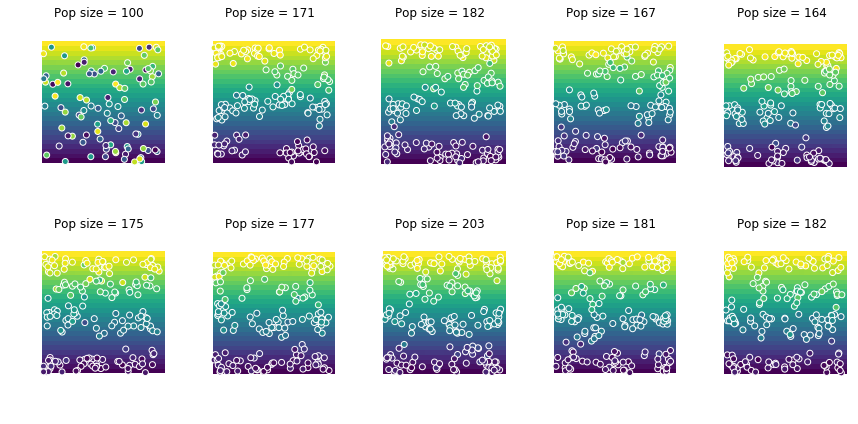

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for ax, gen in zip(axes.ravel(), population.generation.unique()):
    pop = population[population.generation == gen]
    ax.pcolormesh(elevation)
    ax.scatter(pop.x, pop.y, c=pop.trait, edgecolor='w')
    ax.axis('equal')
    ax.set_title('Pop size = %d' % len(pop))
    ax.axis('off')

fig.tight_layout()

In [8]:
def run_model(pop_size, capacity):
    pmodel = ParapatricSpeciationModel(X, Y, pop_size,
                                       nb_radius=5, capacity=capacity,
                                       sigma_w=50, sigma_d=0.5, sigma_mut=50,
                                       lifespan=1, m_freq=0.05)

    pmodel.initialize_population([elevation.min(), elevation.max()])
    
    for step in range(50):
        pmodel.update_population(elevation, 5)

In [9]:
%timeit run_model(100, 28)

60 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit run_model(1000, 280)

3.24 s ± 374 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
